## This is the script to generate Figure S3

In [1]:
library(ggplot2)
library(dplyr)
library(purrr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
dir <- "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2021/velocityRNA/results/combined_analysis/visualize4paper/Figures/"
setwd(dir)
set.seed(8)

In [34]:
#function to take the input of lengths of each exon or intron
#then return the coordinates for plot generation
#type: 'i' for intron, 'e' for exon, 'blank' for blank
accum_lens <- function(lens, types, ymin, ymax, index){
    tot <- 0
    df <- data.frame(start=NULL,end=NULL)
    for(x in lens){
        tot <- tot+x;
        df <- rbind(df,c(tot-x, tot))
    }
    colnames(df) <- c("start", "end")
    df$type <- types
    df$ymin <- ymin
    df$ymax <- ymax
    df$index <- index
    df
}
#intron and exon length
intron_len <- 6
exon_num <- 9
#A vector of the lengths of the exons and introns
lens <- rep(intron_len,exon_num*2) + rep(c(10-intron_len*2,0), exon_num)

#map the y coordinates to generate accumulative lengths
index <- 0
df <- c(0, 14, 21, 28) %>% map_dfr(
    function(x){
        index <- index + 1
        accum_lens(lens, types=rep(c("e", "i"), exon_num), ymin=x, ymax=x+1, index=index)
    }
    
)
x <- -8
df0 <- accum_lens(lens, types=rep(c("e", "i"), exon_num), ymin=x, ymax=x+1, index=1)
x <- 0
df1 <- accum_lens(lens, types=rep(c("e", "i"), exon_num), ymin=x, ymax=x+1, index=1)
x <- 14
df3 <- accum_lens(lens, types=rep(c("e", "i"), exon_num), ymin=x, ymax=x+1, index=3)
x <- 21
df4 <- accum_lens(lens, types=rep(c("e", "i"), exon_num), ymin=x, ymax=x+1, index=4)
x <- 28
df5 <- accum_lens(lens, types=rep(c("e", "i"), exon_num), ymin=x, ymax=x+1, index=5)

#for the exon-exon boundary only reads visualization
lens <- rep(0.1,exon_num*2) + rep(c(10-intron_len-0.1,0), exon_num)
df2 <- accum_lens(lens, types=rep(c("e", "blank"), exon_num), ymin=9, ymax=9+1, index=2)
offset <- 25
df2$start <- df2$start + offset
df2$end <- df2$end + offset

In [35]:
#add reads to one interval
#Args: 
#start_pos_of_the_interval, 
#end_pos_of_the_interval
#number_of_read_coverage (layer)
#current y coordinate
#index
add_reads_one_interval <- function(start, end, read_layer, cur_ymin, index){
    yheight <- 0.3
    ygap <- 0.2
    read_len <- 0.9
    gap_min <- 0.1
    gap_max <- 0.6

    reads <- 1:read_layer %>% map_dfr(
        function(layer){
        ymin <- cur_ymin + (layer - 1) * (yheight + ygap)
        ymax <- ymin + ygap
        seg_num <- ((end - start + gap_min)/(read_len+gap_min)) %>% as.integer()
        lens <- runif(seg_num*2, gap_min, gap_max) * rep(c(0,1), seg_num) + rep(read_len,seg_num*2) * rep(c(1,0), seg_num)
        pos <- accum_lens(lens, types=rep(c("read","gap"), seg_num), ymin=ymin, ymax=ymax, index=index) %>% 
            filter(type=="read")
        #pos
        random_shift <- runif(1, 0, read_len/3)
        pos$start <- pos$start - random_shift
        pos$end <- pos$end - random_shift
        pos
    })
    reads$start <- reads$start + start
    reads$end <- reads$end + start
    
    reads[reads$start >= start - gap_max/2 & reads$end <= end + gap_max/2,]
    
}

#add_reads(start, end, read_layer)

In [36]:
#get the segment data frame for boundary reads
boundary_off <- 0.6
df3_foundary <- df3 %>% filter(type=="i") %>% pmap_dfr(
    function(start, end, type, ymin, ymax, index){
        data.frame(start=c(start-boundary_off, end-boundary_off),
                   end=c(start+boundary_off, end+boundary_off),
                   type=type, ymin=ymin, ymax=ymax, index=index)
        
    }
)
df2_foundary <- df2 %>% filter(type=="blank") %>% pmap_dfr(
    function(start, end, type, ymin, ymax, index){
        data.frame(start=c(start-boundary_off, end-boundary_off),
                   end=c(start+boundary_off, end+boundary_off),
                   type=type, ymin=ymin, ymax=ymax, index=index)
        
    }
)


In [37]:
#add reads to one gene, it will call add_reads_one_interval() to add reads to each its interval
#data frame has to have start, end, type, ymin, ymax and index
exon_read_gap <- 0.25
add_reads_one_gene <- function(df, exon_layers, intron_layers){
    reads <- 1:dim(df)[1] %>% map_dfr(
    function(n){
        x <- df[n,]
        start <- as.numeric(x[1])
        end <- as.numeric(x[2])
        ymin <- as.numeric(x[5]+exon_read_gap)
        index <- as.numeric(x[6])
        read_layer <- ifelse(x[3]=="e", exon_layers, intron_layers)
        read_layer <- as.integer(runif(1, read_layer-1, read_layer+1))
        add_reads_one_interval(start, end, read_layer, ymin+exon_read_gap, index)
        
    }
    )
    reads
}

In [38]:
reads4 <- add_reads_one_gene(df4, 6, 3)
reads5 <- add_reads_one_gene(df5, 11, 3)
reads3 <- add_reads_one_gene(df3_foundary, 0, 3)
reads2 <- add_reads_one_gene(df2_foundary, 0, 3)
reads1 <- add_reads_one_gene(rbind(head(df1, n=4)), 11, 3)
reads0 <- add_reads_one_gene(rbind(tail(df0, n=4)), 11, 3)

In [69]:
#data frame for legends
exon_legend <- tail(df5 %>% filter(type=="e"), n=1)
intron_legend <- tail(df5 %>% filter(type=="i"), n=1)
reads_legend <- add_reads_one_gene(last_exon, 3, 1)

change_legend_pos <- function(df, x=100, y=21){
    delta_x <- x - mean(df$end + df$start)/2
    df <- df %>% mutate(start=start+delta_x, end=end+delta_x)
    delta_y <- y - mean(df$ymin + df$ymax)/2
    df %>% mutate(ymin=ymin+delta_y, ymax=ymax+delta_y)
}

exon_legend <- change_legend_pos(exon_legend, y=34)

intron_legend <- change_legend_pos(intron_legend, y=32)

reads_legend <- change_legend_pos(reads_legend, y = 36)

In [70]:
#concatentate all dataframe for plot generation
all_df <- rbind(df0, df1, df2, df3, df4, df5, reads0, reads1, reads2, reads3, reads4, reads5, exon_legend, intron_legend, reads_legend)

In [71]:
source("/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2021/velocityRNA/results/combined_analysis/visualize4paper/shared/shared.R")

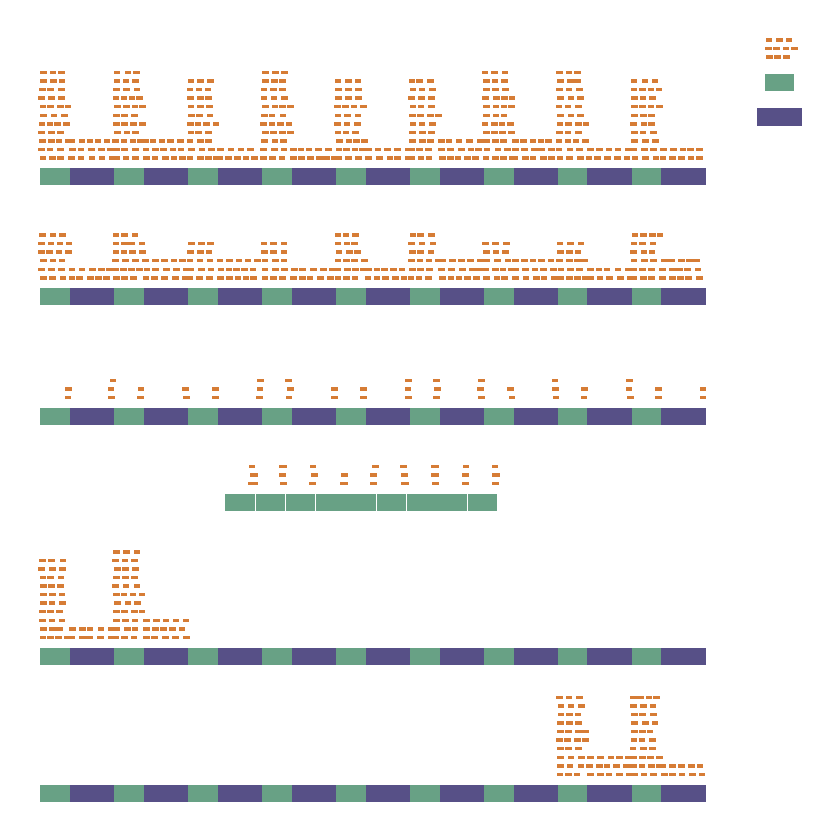

In [76]:
ggplot()+
geom_rect(mapping=aes(xmin=start, xmax=end, ymin=ymin, ymax=ymax, fill=type), all_df) +
theme_void() +
scale_fill_manual(values = c("white", col_sz[c(6,2:3)])) +
theme(legend.position="none")
ggsave("FigureS3_no_text.pdf", width=13, height=8, units="cm")